In [1]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras import Sequential
import gensim
from sklearn.model_selection import train_test_split

In [2]:
# import dataset
df = pd.read_csv("Dataset.csv")
df.head()

,Emotion,Text
0,neutral,@dannycastillo Houston ticket neitu nen kan in...
1,neutral,cant fall muhil thei lo
2,neutral,Balisage Markup Conference 2009 Program-a No T...
3,neutral,@cynthia_123 i muhil thei lo
4,neutral,Bus bl***y chu ka miss ta!!!!!!!!


In [3]:
#shuffle the dataset
df = df.sample(frac = 1)

In [4]:
df.head()

,Emotion,Text
11328,anger,im feeling disgusted already but seriously tho...
1736,sadness,hun kal tawhah ka va let chhak tak em
3918,joy,thu tha tak ani
1311,anger,kha pa min tih dan chu leh
6032,anger,"i huat em em a, ka mualpho bawk"


In [5]:
df.shape

(11922, 2)

In [6]:
df.Emotion.value_counts()

joy        4217
sadness    2848
fear       1748
neutral    1578
anger      1531
Name: Emotion, dtype: int64

In [7]:
# text processing function 
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text) 
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    return text
# Create a new column called "Text" for collecting clean text
df['Text'] = df.Text.apply(lambda x: clean_text(x))

In [8]:
# Stop word in  mizo language
stop_words  = "a, i si a min em  le tak te e in he u tih ka va keimah keini kan keimahni nangmah nangma nangmahni ngei pawh ani amah a ta chu ni chumi anni an engnge khawi tunge hei sawmi hengte hi tawh nei ti mek leh mahse chuan emaw avang angin hma laiin tan hmunah tu nen lam kalh karah chhungah tlang hmaah hnuah chungah hnuai ah atangin chunglam hnuailam chhung pawn titawp hla zawk tichuan vawikhat hetah sawtah engtikah khawnge engati nge engtin zavai engpawh pahnihin vek tlem belh ber thildang engemawzat chutiang aih ve chauh inang chuvangin aiin lutuk thei duhdan chiah don tur tunah"

# Convert to lower case
stop_words = stop_words.lower()

# convert string to list
def Convert(string):
    li = list(string.split(" "))
    return li


stop_word_list = Convert(stop_words)

# Remove stop words
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word_list)]))

In [9]:
# Lable encoding emotions
df["Emotion_encoded"] = df["Emotion"].astype('category').cat.codes # label encoding

# Create a dictionary that maps the category code to its corresponding emotion label
label_map = dict(enumerate(df["Emotion"].astype('category').cat.categories))


In [10]:
label_map

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'neutral', 4: 'sadness'}

In [11]:
df.head()

,Emotion,Text,Emotion_encoded
11328,anger,im feeling disgusted already but seriously tho...,0
1736,sadness,hun kal tawhah let chhak,4
3918,joy,thu tha,2
1311,anger,kha pa dan,0
6032,anger,huat mualpho bawk,0


In [12]:
# Load dataset
texts = df['Text'].values
labels = df['Emotion_encoded'].values

In [14]:
# The hyperparameters required to tune the network.
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [15]:
# Tokenize the text
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [16]:
#pad the sequence to a fixed length
max_length = 100
padded_sequence = pad_sequences(sequences, maxlen=max_length,truncating=trunc_type)

In [17]:
# convert the labels to one-hot encoded vector
num_classes = len(set(labels))
one_hot_labels = np.zeros((len(labels),num_classes))
for i, label in enumerate(labels):
    one_hot_labels[i, label] = 1

In [18]:
one_hot_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
#create list of list from texts for input for word2vec
texts_list = [sentence.split() for sentence in texts]
print(texts_list)

[['im', 'feeling', 'disgusted', 'already', 'but', 'seriously', 'though', 'thlalak', 'lak', 'duh', 'lo', 'cause', 'ive', 'always', 'referred', 'to', 'myself', 'as', 'ugly'], ['hun', 'kal', 'tawhah', 'let', 'chhak'], ['thu', 'tha'], ['kha', 'pa', 'dan'], ['huat', 'mualpho', 'bawk'], ['tleirawl', 'anga', 'new', 'zealand', 'thlenga', 'ram', 'lama', 'zin', 'hmasak', 'thil', 'hlimawm', 'scenery', 'danglam', 'dan', 'etc'], ['enge', 'lan', 'dan'], ['mipuite', 'trih', 'khawp', 'mai'], ['inhnial', 'chuvang', 'sec', 'khat', 'chhungin', 'hna', 'chhuahsan', 'ngai', 'dawn'], ['feel', 'far', 'too', 'distracted', 'to', 'takin', 'thil', 'thupui', 'engmah', 'ziak', 'lo'], ['unaupa'], ['mane', 'thilpek', 'hle', 'lp', 'diary', 'thar', 'of', 'trap', 'god', 'thlawnin', 'tichhuak'], ['ngai', 'che'], ['tun', 'hnaiah', 'lama', 'hun', 'hman', 'danah', 'hian', 'productive', 'takin', 'inhria', 'nun', 'tlangpuiin', 'hlim', 'fate', 'pasal', 'hlim', 'hle', 'bawk'], ['hate', 'living', 'under', 'my', 'dads', 'roof', '

In [20]:
# Train Word2Vec embedding using gensim
gensim_model = gensim.models.Word2Vec(texts_list, min_count = 1, window= 5, workers=4)

In [21]:
gensim_model.save('Word2VecModel.model')

In [22]:
# Get the list of words in the model's vocabulary
vocab_list = gensim_model.wv.index_to_key
print(len(vocab_list))

13007


In [23]:
# Print the first 10 words in the vocabulary
print(vocab_list[:10])

['lo', 'hian', 'ang', 'hria', 'mai', 'hle', 'feel', 'to', 'the', 'im']


In [24]:
# Create the embedding index
embedding_index = {}
for word in gensim_model.wv.key_to_index: # returns a list of the words in the vocabulary in the order of their integer indices.
    embedding_index[word] = gensim_model.wv[word]
    
print(f'loaded {len(embedding_index)} word embedding.')

loaded 13007 word embedding.


In [25]:
# Create Embedding Matrix by selecting the Word2Vec word Embeddings for the word in our vocabulary
word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
model = Sequential()
model.add(Embedding(len(word_index)+1, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = True))
model.add(LSTM(units =64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model.add(LSTM(units =32, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

In [27]:
# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1126400   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           42240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,183,493
Trainable params: 1,183,493
Non-

In [28]:
# Split data into training and validation set
train_sequence, val_sequence , train_labels, val_labels = train_test_split(padded_sequence, one_hot_labels, test_size=0.2)

# Train the model

history = model.fit(train_sequence, train_labels, epochs=10, batch_size = 32, validation_data=(val_sequence, val_labels))


Epoch 1/10
299/299 [==============================] - 84s 260ms/step - loss: 1.4973 - accuracy: 0.3601 - val_loss: 1.3877 - val_accuracy: 0.4021
Epoch 2/10
299/299 [==============================] - 73s 243ms/step - loss: 1.1430 - accuracy: 0.5333 - val_loss: 1.0395 - val_accuracy: 0.6017
Epoch 3/10
299/299 [==============================] - 73s 243ms/step - loss: 0.7121 - accuracy: 0.7369 - val_loss: 1.0052 - val_accuracy: 0.6373
Epoch 4/10
299/299 [==============================] - 72s 239ms/step - loss: 0.4854 - accuracy: 0.8354 - val_loss: 0.9434 - val_accuracy: 0.6935
Epoch 5/10
299/299 [==============================] - 69s 231ms/step - loss: 0.3502 - accuracy: 0.8836 - val_loss: 1.0215 - val_accuracy: 0.6918
Epoch 6/10
299/299 [==============================] - 70s 235ms/step - loss: 0.2899 - accuracy: 0.9051 - val_loss: 1.1348 - val_accuracy: 0.6813
Epoch 7/10
299/299 [==============================] - 69s 230ms/step - loss: 0.2511 - accuracy: 0.9152 - val_loss: 1.2256 - val_ac

In [29]:
test_loss, test_acc = model.evaluate(val_sequence, val_labels)

75/75 [==============================] - 2s 28ms/step - loss: 1.2935 - accuracy: 0.6771


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the predicted and actual labels
y_pred = model.predict(val_sequence)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(val_labels, axis=1)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

75/75 [==============================] - 3s 31ms/step
Accuracy: 0.6771488469601677
Precision: 0.6815897506850753
Recall: 0.6771488469601677
F1 score: 0.6778766937541004


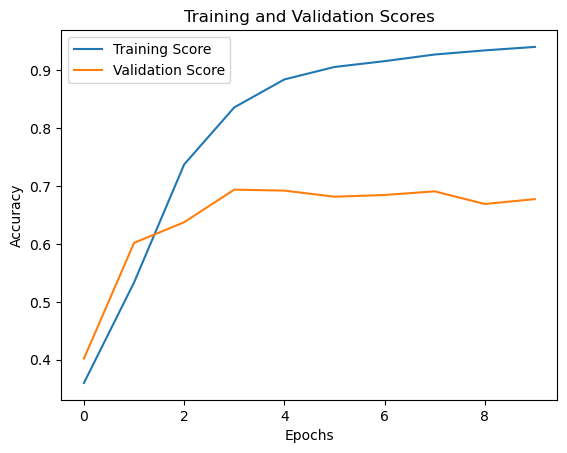

In [31]:
import matplotlib.pyplot as plt

# Get the training and validation scores from the history object returned by the fit() method
train_scores = history.history['accuracy']
val_scores = history.history['val_accuracy']

# Plot the training and validation scores on a line graph
plt.plot(train_scores, label='Training Score')
plt.plot(val_scores, label='Validation Score')
plt.title('Training and Validation Scores')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [32]:
#pipeline for prediction on new data
def predict_emotion(text, model, tokenizer, max_length):
    # Clean the text
    cleaned_text = clean_text(text)
    cleaned_text = ' '.join([word for word in text.split() if word not in (stop_word_list)])
    # Tokenize the text
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])
    
    # Pad the sequence to the fixed length
    padded_sequence = pad_sequences(tokenized_text, maxlen=max_length, truncating=trunc_type)
    
    # Make the prediction
    prediction = model.predict(padded_sequence)[0]
    
    # Get the label with the highest probability
    label_index = np.argmax(prediction)
    
    # Map the label index to its corresponding emotion label
    emotion = label_map[label_index]
    
    return emotion

In [49]:
# Example usage
new_text = "ka hmangaih  "
predicted_emotion = predict_emotion(new_text, model, tokenizer, max_length)
print(predicted_emotion)


1/1 [==============================] - 0s 30ms/step
joy
